# Практическое домашнее задание 1. Поиск похожих изображений с помощью SVD.

Версия от 08.02.2024.

В этой задаче мы познакомимся с одним из возможных приложений сингулярного разложения — поиск "хорошего" базиса (eigenfaces) в наборе изображений и использования его для поиска похожих изображений.

**Замечание:** пользоваться циклами по изображениям **запрещено**, если это явно не прописано в условии.

Для этого сначала загрузим набор изображений, на котором будем обучаться. Это набор фотографий лиц, взятый с [сайта](http://vis-www.cs.umass.edu/lfw/) проекта "Labeled faces in the wild". Скачайте лица людей с именами, начинающимися на "А" и положите в папку `data/` в рабочей директории ноутбука.

Импортируем необходимые библиотеки и загрузим картинки в виде numpy-массивов.

In [70]:
pip install wget

In [71]:
import matplotlib.pyplot as plt
import PIL
import tarfile
import os
import numpy as np

import wget

url = 'http://vis-www.cs.umass.edu/lfw/lfw-a.tgz'
filename = wget.download(url)

def load_images(targz, size):
    images = {}
    tar = tarfile.open(targz, "r:gz")
    for tarinfo in tar:
        if tarinfo.isreg():
            file = tar.extractfile(tarinfo)
            image = PIL.Image.open(file)
            image = image.convert("L")
            image = image.resize(size, PIL.Image.LANCZOS)
            image = np.asarray(image, dtype=np.double)
            image /= np.linalg.norm(image)
            parts = os.path.normpath(tarinfo.name).split(os.path.sep)
            images.setdefault(parts[-2], []).append(image)
    return images

In [72]:
size = 256
images = load_images("lfw-a.tgz", (size, size))

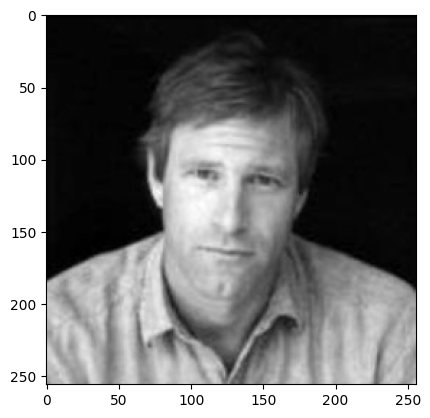

In [73]:
_ = plt.imshow(images["Aaron_Eckhart"][0], cmap="gray")

Сразу отложим одно изображение для последующего поиска.



In [74]:
test_image = images["Alejandro_Toledo"][10]
del images["Alejandro_Toledo"][10]

### a. Применение базового алгоритма SVD (35 баллов)

1. **(4 балла)** С помощью функции ```np.reshape(...)``` получите из словаря `images` массив ```M``` размера ```(size * size, nframes)```, каждым столбцом которого является изображение размера ```(size, size)```, представленное в виде вектора длины ```size**2``` (используйте такое значение параметра `order`, чтобы обходить картинки по столбцам).

*В этом пункте (и только в этом) можно использовать цикл по изображениям.*

In [75]:
M = np.empty((size*size,0))
for i in images:
  for x in images[i]:
    y = x.reshape(size*size,1, order = "F")
    M = np.hstack((M, y))
print(M)

[[0.         0.00830756 0.00757426 ... 0.0039546  0.00665002 0.00521268]
 [0.         0.00851439 0.00757426 ... 0.00443761 0.00665002 0.00521268]
 [0.         0.00854886 0.00757426 ... 0.00476968 0.00665002 0.00521268]
 ...
 [0.00640797 0.00165462 0.0051493  ... 0.00172071 0.00404217 0.        ]
 [0.00670701 0.00148226 0.00517924 ... 0.00175089 0.0038857  0.        ]
 [0.00687789 0.00137885 0.00517924 ... 0.00178108 0.00375531 0.        ]]


In [76]:
print(len(M))

65536


2. **(10 баллов)** Вычислите сингулярное разложение матрицы ```M``` с помощью ```np.linalg.svd``` и постройте график сингулярных чисел, отсортированных по убыванию. Шкала с сингулярными числами должна быть логарифмической. Например, для этого можно использовать функцию ```plt.semilogy```.

    **Замечание:** При построении графиков величин с отличающимися на порядки значениями полезно использовать логарифмическую шкалу. Чтобы убедиться в этом, попробуйте построить график не в логарифмической шкале; из него будет фактически невозможно понять характер убывания сингулярных чисел.

In [77]:
#Найдем сингулярное разложение полученной матрицы:
U, S, V = np.linalg.svd(M, full_matrices = False)

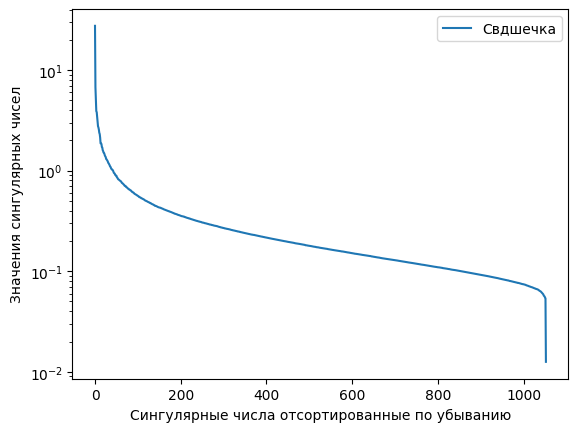

In [78]:
plt.semilogy(S, label = "Свдшечка")
plt.xlabel("Сингулярные числа отсортированные по убыванию")
plt.ylabel("Значения сингулярных чисел")
plt.legend()
plt.show()

 3. **(5 баллов)** Заполните пропуск в следующей функции, которая должна визуализировать вектор-столбцы нашей матрицы в виде таблицы. Затем с её помощью визуализируйте несколько первых сингулярных векторов. Опишите неформально, за что отвечают три старших сингулярных вектора.

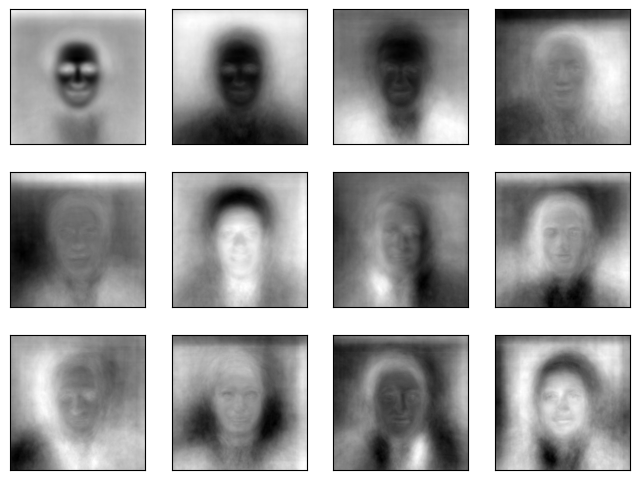

In [79]:
def plot_as_images(mat, rows, cols):
    '''
        Visualize images from the columns of mat in a table of shape (rows, cols).

        Input
            mat: numpy array of shape (size * size, rows * cols)
            rows: number of rows in the table
            cols: number of columns in the table
    '''

    fig, axes = plt.subplots(rows, cols, figsize=(cols*2,rows*2))
    for i in range(rows):
        for j in range(cols):
            axes[i,j].imshow(mat[:,i*cols + j].reshape(256, 256, order = "F"), cmap="gray")
            axes[i,j].get_xaxis().set_visible(False)
            axes[i,j].get_yaxis().set_visible(False)
plot_as_images(U, 3, 4)

Первый сингулярный вектор отвечает за освещение \\
Второй сингулярный вектор описывает силует \\
Третий сингулярный вектор за контрастность \\

4. **(10 баллов)** Напишите функцию ```trunc_svd(M, r)```, которая вычисляет оптимальное приближение $M_{r}$ двумерного массива $M$ заданного ранга. Функция должна возвращать матрицы $U$ и $C$ такие, что столбцы матрицы $U$ составляют ортонормированный базис столбцов $M_{r}$, а $UC = M_{r}$. Также функция `trunc_svd` возвращает **относительную** точность приближения во Фробениусовой норме, т.е.
$$
    \frac{\|M - M_{r}\|_F}{\|M\|_F}.
$$
Для вычисления относительной точности используйте только полученные из сингулярного разложения сингулярные числа.

In [80]:
def trunc_svd(M, r):
    '''
        Input
            M: original 2D numpy array
            r: rank value for truncation

        Output
            U: orthonormal basis of columns of Mr
            C: coefficients in equality Mr = UC
            rel_eps: relative error of rank-r approximation Mr
    '''

    U, S, V = np.linalg.svd(M, full_matrices=False, compute_uv=True)
    U = U[:, :r]
    V = V[:r, :]
    S = S[:r]
    calc_norm = np.square(S**2)
    S = np.diag(S)
    C = S@V
    return U, C, calc_norm/np.linalg.norm(M)


5. **(6 баллов)** Проверим работу написанной функции. Для этого воспользуемся функцией, которая рисует исходное изображение, приближение некоторого ранга, а также первые `count` сингулярных векторов в разложении вместе с их коэффициентами. Заполните пропуски в ней с помощью метода `reshape`.

In [81]:
def plot_as_combination(M, U, C, count, indices):
    '''
        Input
            M: original 2D numpy array
            U: orthonormal basis of columns of Mr
            C: coefficients in equality Mr = UC
            count: desired number of images of singular vectors
            indices: indices of columns of M which are visualized
    '''

    fig, all_axes = plt.subplots(len(indices), count + 2, figsize=(count * 2, len(indices)*2))

    for i, index in enumerate(indices):
        axes = all_axes[i, :]

        axes[0].imshow(M[:,i].reshape(256, 256, order = "F"), cmap="gray") # Original image
        axes[0].set_xlabel("Orig")
        print(len(C[:, index]))
        print(len(U[0]))

        appr = U @ C[:, index]
        appr = appr.ravel()
        axes[1].imshow(appr.reshape(256, 256, order = "F"), cmap="gray") # Approximation image
        axes[1].set_xlabel("Appr")

        for i in range(count):
            axes[2 + i].imshow(U[:,i].reshape(256, 256, order = "F"), cmap="gray") # i-th singular vector image
            axes[2 + i].set_xlabel("{:.7}".format(C[i, index]))

        for ax in axes:
            ax.set_xticks([])
            ax.get_yaxis().set_visible(False)

In [82]:
U, C, eps = trunc_svd(M, 100)

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


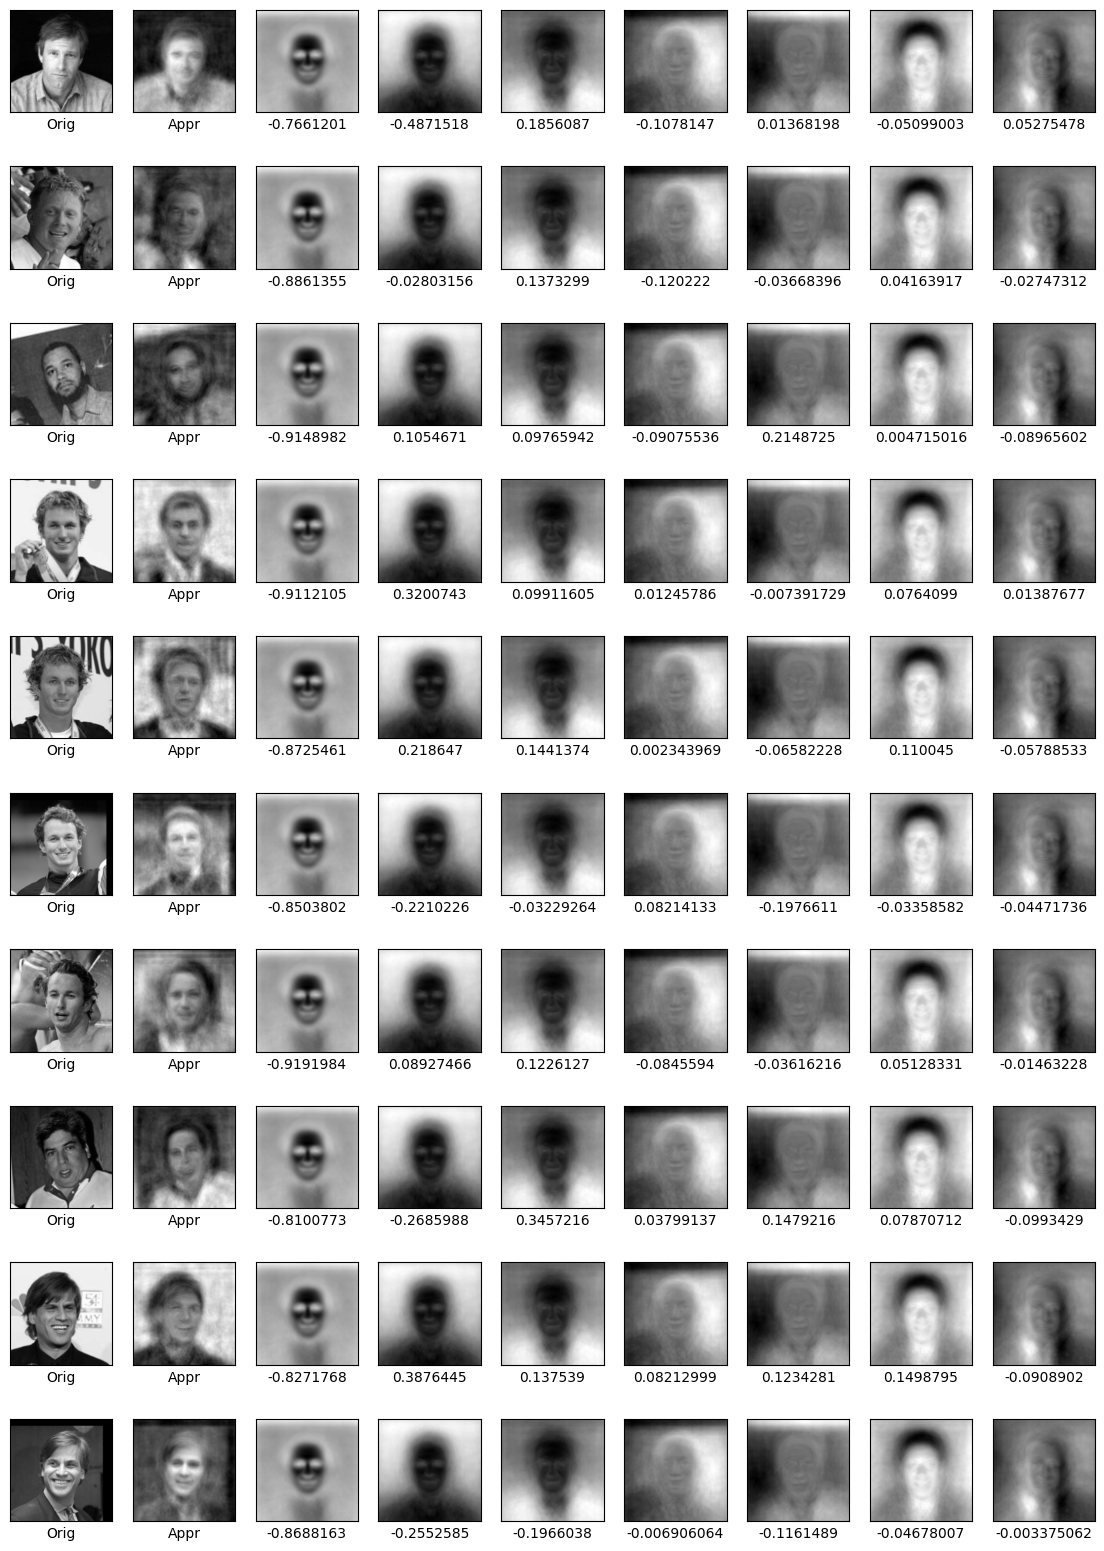

In [83]:
plot_as_combination(M, U, C, 7, range(10))

### b. Применение рандомизированного алгоритма SVD (35 баллов)

Использование функции ```np.linalg.svd``` является эффективным для относительно небольших массивов из-за быстрого (кубического) роста сложности алгоритма в зависимости от размера матрицы. Используем рандомизированный алгоритм из лекций для ускорения вычислений.

1. **(20 баллов)** Реализуйте рандомизированный алгоритм SVD из лекций, который аппроксимирует матрицу с заданным рангом $r$ (алгоритм запускается с ```r + p``` случайных векторов, после чего ранг обрезается до ```r``` с наименьшей ошибкой). Убедитесь, что вы **не вычисляете** в явном виде матрицу $QQ^*$.

In [ ]:
def rand_svd(M, r, p=10):
    '''
        Input
            M: 2D numpy array
            r: rank value for truncation
            p: number of extra random vectors to approximate range(M)

        Output
            Mr: 2D numpy array of rank r and of the same size as M
            rel_eps: relative error of rank-r approximation Mr
    '''
    mat = np.matrix(np.random.randn(len(M[0]), r+p))
    Y = M @ mat
    Q, R = np.linalg.qr(Y)
    Q_t = Q.transpose()
    find_matrix = Q_t @ M
    U, S, V = np.linalg.svd(find_matrix, full_matrices = False)
    S = S[:r]
    S = np.diag(S)
    U = U[:, :r]
    V = V[:r, :]
    return (Q @ U) @ S @ V
#Вспомогательные функции для пункта 2(она совпдадает с транк, просто в контексте этой задачи с ней удобней работать)
def rank_r_svd(M, r):
    U, S, V = np.linalg.svd(M, full_matrices = False)
    S = S[:r]
    S = np.diag(S)
    U = U[:, :r]
    V = V[:r, :]
    return (U @ S) @ V
def func_mistake(M, r, p, rvd):
    return sum((np.linalg.norm(rand_svd(M, r, p) - M)/np.linalg.norm(rvd - M)-1) for _ in range(10))/10

2. **(10 баллов)** Постройте график функции
$$
\frac{||M_{rand}(p) - M||_F}{||M_{SVD} - M||_F} - 1
$$
в зависимости от $p$ для $r=50$. По $p$ выберите сетку $[0, 100]$ с шагом 5.
Так как $M_{rand}(p)$ получено с помощью рандомизированного алгоритма, усредните Ваш результат, запустив алгоритм 10 раз.
При построении графика используйте логарифмическую шкалу.

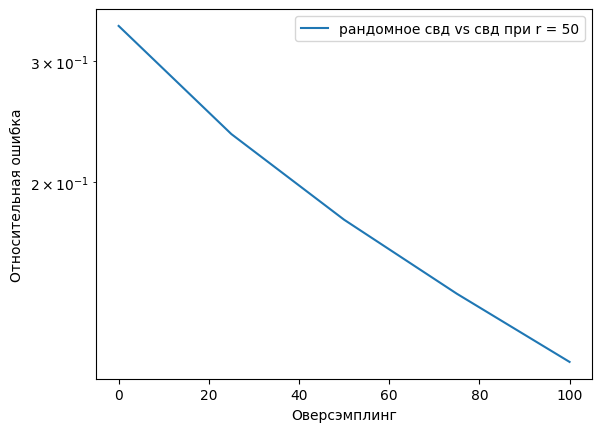

In [ ]:
x = np.linspace(0, 100, 5)
x = x.astype(int)
rvd = rank_r_svd(M, 50)
y = np.array(list(map(lambda value: func_mistake(M, 50, value, rvd), x)))
plt.semilogy(x, y, label = "рандомное свд vs свд при r = 50")
plt.xlabel("Оверсэмплинг")
plt.ylabel("Относительная ошибка")
plt.legend()
plt.show()

3. **(5 баллов)** С помощью ```%timeit``` сравните время расчета для ```trunc_svd``` и ```rand_svd``` для ранга $r = 50$. Во сколько раз рандомизированный алгоритм быстрее ```np.linalg.svd``` для матрицы ```M```?

In [ ]:
%timeit rand_svd(M, 50, 10)
%timeit rank_r_svd(M, 50)

Рандомизированный алгоритм оказался примерно в 14 раз быстрее

### c. Поиск нового изображения (30 баллов)

Представьте, что нам выдали новое изображение `new`, которого в нашей базе нет. Чтобы найти в базе похожие, можно посчитать норму разности с каждым имеющимся изображением. Для проверки напишем вспомогательную функцию, которая будет показывать подписанные картинки.

In [84]:
def show_images(M, indices, names):
    fig, axes = plt.subplots(1, len(indices), figsize=(len(indices)*3, 3))
    for ax, index in zip(axes, indices):
        ax.imshow(M[:,index].reshape((size, size), order='F'), cmap="gray")
        ax.get_xaxis().set_ticks([])
        ax.set_xlabel(names[index])
        ax.get_yaxis().set_visible(False)

   1. **(10 баллов)** Напишите функцию, находящее ближайшее во фробениусовой норме изображение.

In [85]:
#Вспомогательная функция
def curF(curcol, new):
    return np.linalg.norm(new - curcol)
#Непосредственно поиск ближайшего
def get_closest_naive(M, new_v, count):
    """
        Input
            M: matrix of vectorized images
            new_v: new image as a vector of shape (size**2,)
            count: desired number of closest images

        Output
            indices: list of count indices of closest images
    """
    res = np.apply_along_axis(curF, axis = 0, arr = M, new = new_v)
    best_indices = np.argsort(res)[:count]
    return best_indices

Проверим её на тестовом изображении. Как минимум один Алехандро Толедо должен найтись.

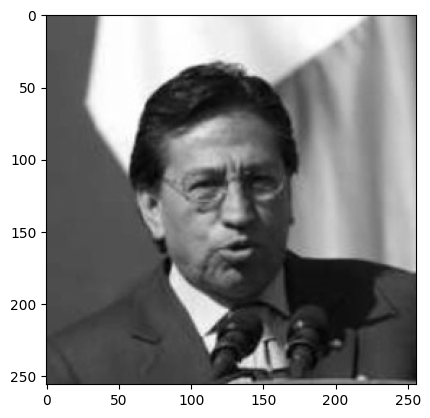

In [86]:
new = test_image
_ = plt.imshow(new, cmap="gray")

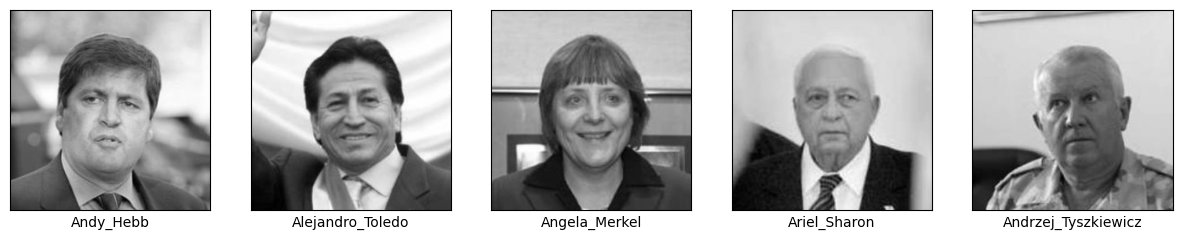

In [87]:
new_v = new.ravel(order="F")
names = sum(map(lambda item: [item[0]] * len(item[1]), images.items()), [])
show_images(M, get_closest_naive(M, new_v, 5), names)

Помимо того, что такой подход может оказаться неприемлемым с точки зрения производительности, он также не устойчив:  например, изменение освещения или фона может очень сильно изменить норму разности.

   2. **(20 баллов)** Применим подход, использующий SVD. Именно, спроецируем новое изображение на пространство, задаваемое ортонормированным базисом $U$, и будем сравнивать норму разности проекций. Причём для устойчивости к изменению освещения не будем учитывать первую компоненту в разложении по столбцам матрицы $U$. Напишите функцию `get_closest_proj`, которая возвращает индексы `count` изображений по описанному алгоритму.

In [88]:
def get_closest_proj(U, C, new_v, count):
    """
        Input
            U: orthonormal basis of columns of Mr
            C: coefficients in equality Mr = UC
            new_v: new image as a vector of shape (size**2,)
            count: desired number of closest images

        Output
            indices: list (of len `count`) of indices of closest images
    """
    ##Получаем проекцию матрицы M и проекцию вектора v на подпространство
    Mr = U @ C
    vec = U @ (U.T @ new_v)
    #Выкинем первую компоненту
    Mr = Mr[1:, :]
    vec = vec[1:]
    return get_closest_naive(Mr, vec, count)

Проверим подход с SVD  том же тестовом изображении. Правильно реализованный метод должен найти как минимум два изображения Алехандро.

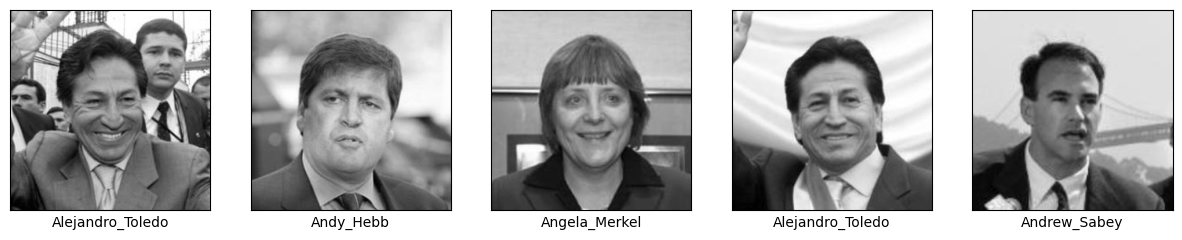

In [89]:
show_images(M, get_closest_proj(U, C, new_v, 5), names)

### c. Бонус

В бонусной части мы познакомимся с более продвинутыми рандомизированными алгоритмами поиска сингулярного разложения. Условие заданий базируется на статье

Halko, Nathan, Per-Gunnar Martinsson, and Joel A. Tropp. "Finding structure with randomness: Probabilistic algorithms for constructing approximate matrix decompositions." SIAM review 53.2 (2011): 217-288.

**Ссылка на статью**: http://users.cms.caltech.edu/~jtropp/papers/HMT11-Finding-Structure-SIREV.pdf

1. **(50 б. баллов)** Докажите, что в точной арифметике результат, полученный при использовании Алгоритма 4.3 и 4.4 из статьи, указанной выше, совпадают. Все теоретические выкладки приведите в текущем файле с использованием Markdown или прикрепите качественное изображение рукописного текста.

2. **(50 б. баллов)** Реализуйте Алгоритм 4.4 и используйте его для построения приближенного сингулярного разложения матрицы A на матрице из этой ДЗ. Зафиксируйте ранги $r=5, 20, 50$. Для каждого из этих значений на одном рисунке постройте график зависимости нормы (на выбор) разности полученного приближения и оптимального приближения (в выбранной норме) того же ранга от числа q.

### 1 Бонуска ###
Сначала докажем вспомогательную лемму:
Обратная матрица к полноранговой верхнетреугольной матрице - верхнетреугольна.
Докажем по индукции: \\
Матрица $1*1$ - очев.\
Переход:\
Пусть мы доказали для матрицы $n*n$, докажем для матрицы $(n+1)*(n+1)$\
$\left(\begin{matrix}
x1 & A \\
0 & B
\end{matrix}\right)$ пусть наша матрица имеет такой блочно-диагональный вид, где $x1$ - блок размера 1*1. Попробуем показать что для данной матрицы обратная матрица имеет вид
$\left(\begin{matrix}
x1^{-1} & Y \\
0 & B^{-1}
\end{matrix}\right)$, где $Y$ - произвольная матрица.\
Рассмотрим произведение этих матриц:
$\left(\begin{matrix}
x1 & A \\
0 & B
\end{matrix}\right)$
*
$\left(\begin{matrix}
x1^{-1} & Y \\
0 & B^{-1}
\end{matrix}\right)$
=
$\left(\begin{matrix}
1 & x1A + YB^{-1} \\
0 & E
\end{matrix}\right)$, так как $B$ - полноранговая матрица можно подобрать такой вектор-строку Y, который зануляет правый верхний угол.\
Значит обратная матрица имеет нужный нам вид.\
Тогда так как обратная матрица для B - верхнетреугольная(по предположению индукции), то и полученная обратная матрица верхнетреугольная => утверждение доказано.
Лемма доказана.\
Теперь перейдем непосредственно к доказательству теоремы.\
Рассмотрим $QR$ разложения из алгоритма 4.4:\
$\widetilde{Y_{j}} = A^{*}Q_{j-1}$, $Y_{j} = A\widetilde{Q_{j-1}}$.\
Где матрица $\widetilde{Q_{j-1}}$ из $QR$ разложения $\widetilde{Y_{j}}$.
$\widetilde{Y_{j}} = \widetilde{Q_{j-1}} \widetilde{R_{j}} $\
Преобразуем последнее равенство:
$\widetilde{Q_{j-1}} = \widetilde{Y_{j}} * (\widetilde{R_{j}})^{-1}$ и подставим его во второе равенство:\
$Y_{j} = A*\widetilde{Y_{j}} * (\widetilde{R_{j}})^{-1}$, а теперь применим доказанную ранее лемму: Обратная матрица для верхнетреугольной полноранговой матрицы - верхнетреугольная.\
Теперь вспомним как мы получаем матрицу $Q_{j}$ для следующей итерации алгоритма. Хмм, это же матрица из $QR$ разложения для матрицы $Y_{j}$, но так как $Y_{j} = A*\widetilde{Y_{j}} * (\widetilde{R_{j}})^{-1}$, а $(\widetilde{R_{j}})^{-1}$ - верхнетреугольная матрица, то $QR$ для матрицы $Y_{j}$ совпадает с $QR$ разложением матрицы $A*\widetilde{Y_{j}}$(так как произведение верхнетреугольных матриц - верхнетреугольная матрица). $A\widetilde{Y_{j}} = AA^{*}Q_{j-1}$. Теперь распишем $QR$:
$Q_{j}R_{j} = AA^{*}Q_{j-1}$, $Q_{j}R_{j}Q_{j-1}^{*} = AA^{*}$, в силу ортогональности $Q_{j-1}$.\
А теперь вспомним что $AΘ = Q_{0}R_{0}$.\
Перемножим эти штуки по всем j: $\prod\limits_{j = 1}^q Q_{j}R_{j}Q_{j-1}^{*} = Q_{q} * \prod\limits_{j = 1}^q R_{j} * Q_{0}^{*} = (AA^{*})^{q}$, в силу того что ортогональные матрицы сократились.\
 $\prod\limits_{j = 1}^q R_{j} = R_{prod}$, где $R_{prod}$ - верхнетреугольная.
 Домножим обе части справа на $Q_{0}R_{0}$ и мы получим матрицу $Y$ из алгоритма 4.3. \
 $Q_{q} * R_{prod} * Q_{0}^{*} * Q_{0} * R_{0} = Q_{q} * (R_{prod} * R_{0})$, значит матрица из $QR$ разложения из матрицы $Y$ и есть $Q^{q}$, что в целом и требовалось доказать.

In [ ]:
### 2 бонуска
### Сам код рандомного свд
def rand_comp_4(M, r, q):
    '''
        Input
            M: 2D numpy array
            r: rank value for truncation
            p: number of extra random vectors to approximate range(M)

        Output
            Mr: 2D numpy array of rank r and of the same size as M
            rel_eps: relative error of rank-r approximation Mr
    '''
    mat = np.matrix(np.random.randn(len(M[0]), r))
    Y = M @ mat
    Q, R = np.linalg.qr(Y)
    for j in range(1, q + 1):
      Y_j_tilda = M.transpose() @ Q
      Q_tilda, R_tilda = np.linalg.qr(Y_j_tilda)
      Y_tilda = M @ Q_tilda
      Q, R = np.linalg.qr(Y_tilda)
    return Q @ (Q.transpose() @ M)

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]


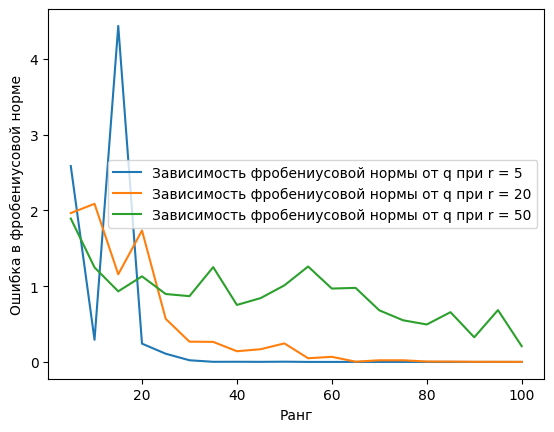

In [ ]:
### Теперь построим красивый график
r_s = [5, 20, 50]
q_s = [5*i for i in range(1, 21)]
print(q_s)
for r in r_s:
  rvd = rank_r_svd(M, r)
  norms = []
  for q in q_s:
    norms = np.append(norms, np.linalg.norm(rvd - rand_comp_4(M, r, q)))
  plt.plot(q_s, norms, label = f"Зависимость фробениусовой нормы от q при r = {r}")
plt.xlabel("Ранг")
plt.ylabel("Ошибка в фробениусовой норме")
plt.legend()
plt.show()



